In [ ]:

from sklearn.datasets import load_iris

iris = load_iris() #  アイリスデータセットの読み込み

#print(iris.DESCR)

print(type(iris))

<class 'sklearn.utils.Bunch'>


In [ ]:

import pandas as pd

df = pd.DataFrame(iris.data, columns=iris.feature_names) #データフレーム型に格納、特徴量の名前を列に加える
print(df.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2


In [ ]:
df['Variety'] = iris.target #ターゲットデータ（教師データ）もデータフレームに格納,　そのためにアイリスデータのターゲットを引っ張ってきている 

df.loc[df['Variety'] == 0, 'Variety'] = 'setosa'
df.loc[df['Variety'] == 1, 'Variety'] = 'versicolor'
df.loc[df['Variety'] == 2, 'Variety'] = 'virginica'

print(df.head())

   sepal length (cm)  sepal width (cm)  ...  petal width (cm)  Variety
0                5.1               3.5  ...               0.2   setosa
1                4.9               3.0  ...               0.2   setosa
2                4.7               3.2  ...               0.2   setosa
3                4.6               3.1  ...               0.2   setosa
4                5.0               3.6  ...               0.2   setosa

[5 rows x 5 columns]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim

iris = load_iris()
data = iris.data
label = iris.target

print(type(data)) #ndarray型
print(type(label))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
train_data, test_data, train_label, test_label = train_test_split( # trainデータとtestデータに分割、validationデータもいずれ作ろう！
    data, label, test_size=0.2)
print("train_data size: {}".format(len(train_data)))
print("test_data size: {}".format(len(test_data)))
print("train_label size: {}".format(len(train_label)))
print("test_label size: {}".format(len(test_label)))

print(type(train_data)) #型は変わらない


train_data size: 120
test_data size: 30
train_label size: 120
test_label size: 30
<class 'numpy.ndarray'>


In [ ]:
# 型をテンソルに変える
train_x = torch.Tensor(train_data)
test_x = torch.Tensor(test_data)
train_y = torch.LongTensor(train_label)
test_y = torch.LongTensor(test_label) 
print(type(train_x))

# データをテンソルのデータにセットする.       引数として　入力データ, 教師データ とすれば良い
train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)
print(type(train_dataset))

<class 'torch.Tensor'>
<class 'torch.utils.data.dataset.TensorDataset'>


In [ ]:

# データローダーの際の細かい設定をする
train_batch = DataLoader(
    dataset = train_dataset,#データセットの指定
    batch_size = 5,#バッチサイズの指定
    shuffle = True,#シャッフルするかどうかの指定
    num_workers = 2#コア数
)
test_batch = DataLoader(
    dataset = test_dataset,
    batch_size = 5,
    shuffle = False,
    num_workers = 2
)
## for文で回してサイズを確認する
for data, label in train_batch:
    print("batch data size: {}".format(data.size())) #バッチサイズが5, 特徴量（軸）が4つと分かる
    print("batch label size: {}".format(label.size())) #バッチサイズはもちろん上と同じ5, クラスが入っている
    break

batch data size: torch.Size([5, 4])
batch label size: torch.Size([5])


In [ ]:
# ニューラルネットワークを作成
class Net(nn.Module):
  def __init__(self, D_in, H, D_out): # モデルの定義.　重み, バイアスの初期化やその際のシード値固定もいずれしよう！
    super(Net, self).__init__()
    self.linear1 = torch.nn.Linear(D_in, H)
    self.linear2 = torch.nn.Linear(H, D_out)
  def forward(self, x):  # 順伝播の際の動きをプログラムする
    x = F.relu(self.linear1(x))
    x = self.linear2(x)
    return x


In [ ]:
## パラメータ表示
#ハイパーパラメータ
D_in = 4#入力次元
H = 100#隠れ層次元
D_out = 3#出力次元
epoch = 10#学習回数
## デバイスの指定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
## ネットワーク実行
net = Net(D_in, H, D_out).to(device)
print("Device: {}".format(device))

Device: cpu


In [ ]:

#使用する損失関数の定義
criterion = nn.CrossEntropyLoss()
#使用する最適化関数の定義
optimizer = optim.Adam(net.parameters())


In [ ]:

## 学習に必要な空リストを作成
train_loss_list = []#学習損失
train_accuracy_list = []#学習データ正解率
test_loss_list = []#評価損失
test_accuracy_list = []#テストデータの正答率



#学習の実行
for I in range(epoch):
    #学習の進行状況を表示
    print('--------')
    print("Epoch: {}/{}".format(I + 1, epoch))
    #損失と正解率の初期化
    train_loss = 0#学習損失
    train_accuracy = 0#学習データの正答数
    test_loss = 0#評価損失
    test_accuracy = 0#テストデータの正答数
    #学習モードに設定
    net.train()
    #ミニバッチごとにデータをロードして学習
    for data, label in train_batch:
        data = data.to(device)
        label = label.to(device)
        #勾配を初期化
        optimizer.zero_grad()
        #データを入力して予測値を計算
        y_pred_prob = net(data)
        #損失を計算
        loss = criterion(y_pred_prob, label)
        #勾配を計算
        loss.backward()
        #パラメータの更新
        optimizer.step()
        #ミニバッチごとの損失を蓄積
        train_loss += loss.item()
        #予測したラベルを予測確率から計算
        y_pred_label = torch.max(y_pred_prob, 1)[1]
        #ミニバッチごとに正解したラベル数をカウント
        train_accuracy += torch.sum(y_pred_label == label).item() / len(label)
    #ミニバッチの平均の損失と正解率を計算
    batch_train_loss = train_loss / len(train_batch)
    batch_train_accuracy = train_accuracy / len(train_batch)
    #評価モードに設定
    net.eval()
    #評価時に自動微分をゼロにする
    with torch.no_grad():
        for data, label in test_batch:
            data = data.to(device)
            label = label.to(device)
            #データを入力して予測値を計算
            y_pred_prob = net(data)
            #損失を計算
            loss = criterion(y_pred_prob, label)
            #ミニバッチごとの損失を備蓄
            test_loss += loss.item()
            #予測したラベルを予測確率から計算
            y_pred_label = torch.max(y_pred_prob, 1)[1]
            #ミニバッチごとに正解したラベル数をカウント
            test_accuracy += torch.sum(y_pred_label == label).item() / len(label)
    #ミニバッチの平均の損失と正解率を計算
    batch_test_loss = test_loss / len(test_batch)
    batch_test_accuracy = test_accuracy / len(test_batch)

    #エポックごとに損失と正解率を表示
    print("Train_Loss: {:.4f} Train_Accuracy: {:.4f}".format(batch_train_loss, batch_train_accuracy))
    print("Test_Loss: {:.4f} Test_Accuracy: {:.4f}".format(batch_test_loss, batch_test_accuracy))



    #損失と正解率をリスト化して保存
    train_loss_list.append(batch_train_loss)
    train_accuracy_list.append(batch_train_accuracy)
    test_loss_list.append(batch_test_loss)
    test_accuracy_list.append(batch_test_accuracy)

--------
Epoch: 1/100
Train_Loss: 1.0194 Train_Accuracy: 0.4917
Test_Loss: 0.8445 Test_Accuracy: 0.8000
--------
Epoch: 2/100
Train_Loss: 0.8138 Train_Accuracy: 0.6667
Test_Loss: 0.6959 Test_Accuracy: 0.7000
--------
Epoch: 3/100
Train_Loss: 0.6844 Train_Accuracy: 0.7417
Test_Loss: 0.5646 Test_Accuracy: 0.9000
--------
Epoch: 4/100
Train_Loss: 0.6096 Train_Accuracy: 0.7083
Test_Loss: 0.4862 Test_Accuracy: 0.9667
--------
Epoch: 5/100
Train_Loss: 0.5445 Train_Accuracy: 0.8250
Test_Loss: 0.4706 Test_Accuracy: 0.6667
--------
Epoch: 6/100
Train_Loss: 0.4977 Train_Accuracy: 0.7750
Test_Loss: 0.3927 Test_Accuracy: 0.9667
--------
Epoch: 7/100
Train_Loss: 0.4629 Train_Accuracy: 0.8667
Test_Loss: 0.3922 Test_Accuracy: 0.7667
--------
Epoch: 8/100
Train_Loss: 0.4363 Train_Accuracy: 0.8833
Test_Loss: 0.3513 Test_Accuracy: 0.9667
--------
Epoch: 9/100
Train_Loss: 0.4139 Train_Accuracy: 0.9083
Test_Loss: 0.3327 Test_Accuracy: 0.9667
--------
Epoch: 10/100
Train_Loss: 0.3988 Train_Accuracy: 0.9500

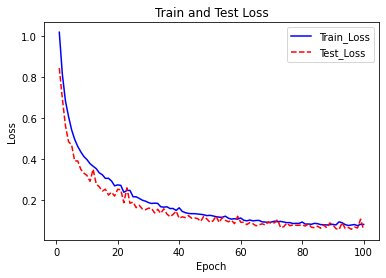

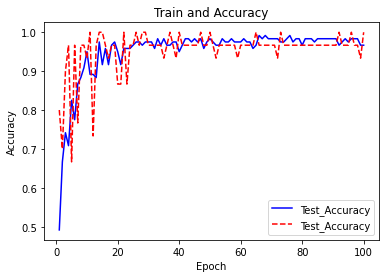

In [ ]:


plt.figure()
plt.title('Train and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, epoch+1), train_loss_list, color='blue',linestyle='-', label='Train_Loss')
plt.plot(range(1, epoch+1), test_loss_list, color='red', linestyle='--', label='Test_Loss')
plt.legend()

plt.figure()
plt.title('Train and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(range(1, epoch+1), train_accuracy_list, color='blue', linestyle='-', label='Test_Accuracy')
plt.plot(range(1, epoch+1), test_accuracy_list, color='red', linestyle='--', label='Test_Accuracy')
plt.legend()

plt.show()